# **Cloud Threat Detection using LSTM Model**

## **1. Importing Libraries**

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping  # to stop model training on conditions
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## **2. Loading, Cleaning and Preprocessing of Data**

In [30]:
# Load timestamped CPU utilization data and preprocess the data
data = pd.read_csv('/kaggle/input/aws-ec2-instance-metric-cpu-utilization-daily/aws_ec2_instance_metric_cpu_utilization_daily.csv')

# timestamp column is converted to datetime format and set as index for time based analysis
data['timestamp'] = pd.to_datetime(data['timestamp'])  
data.set_index('timestamp', inplace=True)

In [31]:
# Use only 'maximum' column for prediction
data = data[['maximum']]   # It represents  maximum CPU Utilization
data = data.resample('D').mean()  # data is resampled on daily basis 
data = data.fillna(method='ffill')
print(data.head(30))

                             maximum
timestamp                           
2022-12-21 00:00:00+00:00  11.750392
2022-12-22 00:00:00+00:00  11.750392
2022-12-23 00:00:00+00:00  11.750392
2022-12-24 00:00:00+00:00  11.750392
2022-12-25 00:00:00+00:00  11.750392
2022-12-26 00:00:00+00:00  11.750392
2022-12-27 00:00:00+00:00  11.825197
2022-12-28 00:00:00+00:00   3.274891
2022-12-29 00:00:00+00:00   3.274891
2022-12-30 00:00:00+00:00   3.274891
2022-12-31 00:00:00+00:00   3.274891
2023-01-01 00:00:00+00:00   3.274891
2023-01-02 00:00:00+00:00   3.274891
2023-01-03 00:00:00+00:00   3.274891
2023-01-04 00:00:00+00:00   3.274891
2023-01-05 00:00:00+00:00   3.274891
2023-01-06 00:00:00+00:00   3.274891
2023-01-07 00:00:00+00:00   3.274891
2023-01-08 00:00:00+00:00  24.333333
2023-01-09 00:00:00+00:00  56.000000
2023-01-10 00:00:00+00:00  23.666667
2023-01-11 00:00:00+00:00  23.666667
2023-01-12 00:00:00+00:00  23.666667
2023-01-13 00:00:00+00:00  23.666667
2023-01-14 00:00:00+00:00  28.700000
2

* #### **Normalization of Data**

In [32]:
# Normalize the data
scaler = MinMaxScaler()  # used to scale the data between 0 and 1 
data_scaled = scaler.fit_transform(data)

* #### **Seperating dataset with validation**

In [33]:
train_size = int(len(data) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# import tensorflow as tf

# def get_dataset_partitions_tf(ds, train_split=0.80, val_split=0.10, test_split=0.10, shuffle=True, shuffle_size=10000):
    
#     # Check if the sum of the splits is equal to 1
#     assert abs((train_split + test_split + val_split) - 1) < 1e-10
    
#     ds_size = len(ds)  # Get the size of the dataset
#     print('Dataset length: ', ds_size)
    
#     # Convert the NumPy array to a TensorFlow dataset
#     ds = tf.data.Dataset.from_tensor_slices(ds)
    
#     # Shuffle the dataset if enabled
#     if shuffle:
#         ds = ds.shuffle(shuffle_size, seed=12) # Shuffle the dataset using a specified seed
    
#     # Calculate the sizes for train, validation, and test sets
#     train_size = int(train_split * ds_size)
#     val_size = int(val_split * ds_size)
    
#     # Split the dataset into train, validation, and test sets
#     train_ds = ds.take(train_size)   # Take the first train_size elements as the train set
#     val_ds = ds.skip(train_size).take(val_size)   # Skip the train_size elements and take the next val_size elements as the validation set
#     test_ds = ds.skip(train_size + val_size)   # Skip the train_size and val_size elements to get the remaining elements as the test set
    
#     return train_ds, test_ds, val_ds

In [34]:
# train_ds, test_ds, val_ds = get_dataset_partitions_tf(data_scaled)

* #### **Preprocessing and Optimisation of Dataset objects**

In [35]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# def create_sequences(ds, look_back):
#     X, y = [], []
#     for batch in ds:
#         for i in range(len(batch) - look_back):
#             X.append(batch[i:i+look_back])
#             y.append(batch[i+look_back])
#     return np.array(X), np.array(y)

In [37]:

# # Create sequences for the training data
# X_train, y_train = create_sequences(train_ds, look_back)

# # Create sequences for the validation data
#  X_val, y_val = create_sequences(val_ds, look_back)

# # Create sequences for the test data
# X_test, y_test = create_sequences(test_ds, look_back)

look_back = 30
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

## **3. LSTM Model**

In [38]:
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))  # return sequences to stack
model.add(Dropout(0.2))  # Add dropout between layers to reduce overfitting
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [39]:

history = model.fit(X_train, y_train,epochs = 50, batch_size=64,verbose=2)

Epoch 1/50
4/4 - 3s - loss: 0.0473 - mean_squared_error: 0.0473 - 3s/epoch - 797ms/step
Epoch 2/50
4/4 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - 26ms/epoch - 6ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0216 - mean_squared_error: 0.0216 - 25ms/epoch - 6ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - 25ms/epoch - 6ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0220 - mean_squared_error: 0.0220 - 25ms/epoch - 6ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0213 - mean_squared_error: 0.0213 - 25ms/epoch - 6ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0217 - mean_squared_error: 0.0217 - 25ms/epoch - 6ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0205 - mean_squared_error: 0.0205 - 26ms/epoch - 7ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0205 - mean_squared_error: 0.0205 - 25ms/epoch - 6ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0204 - mean_squared_error: 0.0204 - 26ms/epoch - 6ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0199 - mean_squared_error: 0.0199 - 30ms/epoch - 7ms/step
Epoch 12/50
4/4 - 0s - loss: 0

In [40]:
y_pred = model.predict(X_test)
# Reshape y_pred
y_pred = y_pred.reshape(-1, 1)

# Inverse transform to the original scale
y_pred = scaler.inverse_transform(y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data[train_size + look_back:  train_size + look_back + 870], y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

1/1 [==============================] - 1s 635ms/step
Root Mean Squared Error (RMSE): 19.280851942322727


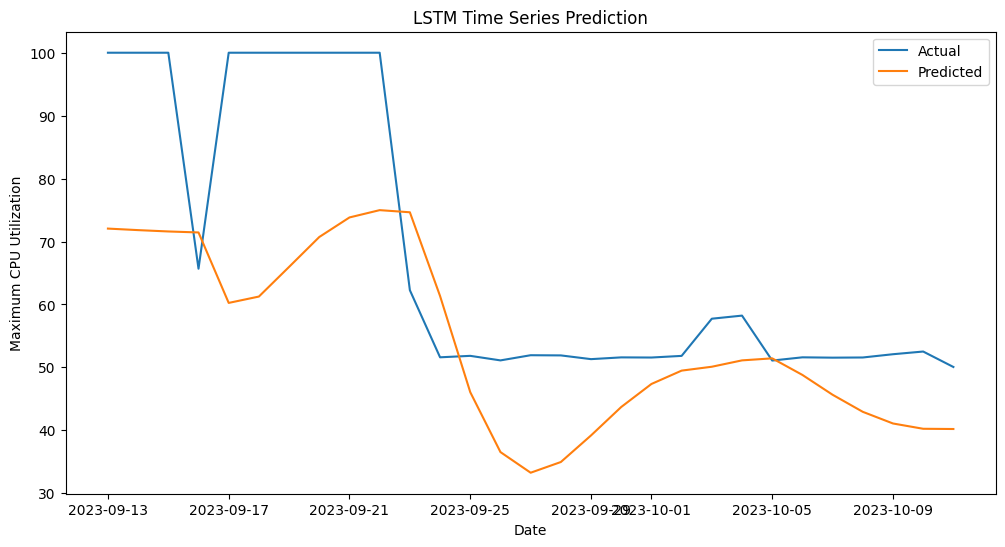

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + look_back:], data[train_size + look_back:], label='Actual')
plt.plot(data.index[train_size + look_back:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum CPU Utilization')
plt.legend()
plt.title('LSTM Time Series Prediction')
plt.show()

## Streamlit Code

In [42]:
import streamlit as st


# Create a Streamlit app
st.title("LSTM Time Series Prediction")

# Function to load and preprocess data
@st.cache
def load_and_preprocess_data():
    # Load the dataset
    data = pd.read_csv('/kaggle/input/aws-ec2-instance-metric-cpu-utilization-daily/aws_ec2_instance_metric_cpu_utilization_daily.csv')

    # Data preprocessing
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    data = data[['maximum']]
    data = data.resample('D').mean()
    data = data.fillna(method='ffill')

    # Data normalization
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data, data_scaled

data, data_scaled = load_and_preprocess_data()

# Sidebar for user input
st.sidebar.header("Model Configuration")
look_back = st.sidebar.number_input("Look-back Window Size", min_value=1, max_value=100, value=30)
epochs = st.sidebar.number_input("Number of Epochs", min_value=1, max_value=100, value=50)
batch_size = st.sidebar.number_input("Batch Size", min_value=1, value=64)

# Split data into training and test sets
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Create sequences
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

st.sidebar.text("Training the model...")
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
st.sidebar.text("Model training completed.")

# Make predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data[train_size + look_back: train_size + look_back + len(y_pred)], y_pred))

# Visualization
st.header("Results")
st.subheader("Root Mean Squared Error (RMSE)")
st.write(f"RMSE: {rmse}")

st.subheader("Predicted vs. Actual Data")
fig, ax = plt.subplots()
ax.plot(data.index[train_size + look_back:], data[train_size + look_back:], label='Actual')
ax.plot(data.index[train_size + look_back:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum CPU Utilization')
plt.legend()
st.pyplot(fig)

ModuleNotFoundError: No module named 'streamlit'